In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Parameters
kv_cache_dir = "kv_cache/crumb/nano-mistral/wikitext/fp32"  # Directory with KV cache files
output_dir = "cluster_results/crumb/nano-mistral/wikitext/fp32"  # Directory to save clustering results
os.makedirs(output_dir, exist_ok=True)

page_size = 16  # Maximum number of tokens per cluster
beta = 0.5  # Weight for temporal similarity
alpha = 0.1  # Temporal decay factor
num_tokens_to_process = 100  # Limit the number of tokens to process for efficiency

def load_kv_cache(layer_idx):
    """Load KV cache for a specific layer."""
    kv_file = os.path.join(kv_cache_dir, f"kv_cache_layer_{layer_idx}.pkl")
    if not os.path.exists(kv_file):
        raise FileNotFoundError(f"KV cache file for layer {layer_idx} not found: {kv_file}")
    
    print(f"Loading KV cache from {kv_file}...")
    with open(kv_file, "rb") as f:
        kv_cache = pickle.load(f)
    return kv_cache

def pad_to_match(arrays):
    """Pad arrays to match dimensions along the concatenation axis."""
    max_dim = max(a.shape[2] for a in arrays)  # Find the maximum size along the mismatched axis
    print(f"Padding arrays to match dimension: max_dim={max_dim}")
    padded_arrays = []
    for array in arrays:
        pad_width = [(0, 0)] * array.ndim
        pad_width[2] = (0, max_dim - array.shape[2])  # Pad only the mismatched axis
        padded_arrays.append(np.pad(array, pad_width, mode='constant'))
    return np.concatenate(padded_arrays, axis=0)

def pad_selected(arrays, min_limit = 50, pad_or_neglect = "neglect"):
    padded_arrays = []
    for array in arrays:
        if array.shape[2]<min_limit:
            if pad_or_neglect == "neglect":
                pass
            else:
                pad_width = [(0, 0)] * array.ndim
                pad_width[2] = (0, min_limit- array.shape[2])  # Pad only the mismatched axis
                padded_arrays.append(np.pad(array, pad_width, mode='constant'))
        else:
            padded_arrays.append(array[:,:,:min_limit,:])
            
    return np.concatenate(padded_arrays, axis=0)
            
def compute_temporal_similarity(t1, t2):
    """Compute temporal similarity based on token indices."""
    return np.exp(-alpha * abs(t1 - t2))

def perform_clustering_with_similarities(layer_idx, kv_cache, beta, page_size, num_tokens_to_process):
    """Cluster tokens and calculate similarities for each pair within clusters."""
    keys = pad_to_match(kv_cache["keys"])
    num_tokens = min(keys.shape[0], num_tokens_to_process)

    # Compute semantic similarity (cosine similarity)
    print("Calculating semantic similarity...")
    semantic_sim = cosine_similarity(keys[: ].reshape(num_tokens, -1))

    # Initialize hybrid similarity matrix
    hybrid_sim = np.zeros_like(semantic_sim)
    for i in range(num_tokens):
        for j in range(num_tokens):
            temporal_sim = compute_temporal_similarity(i, j)
            hybrid_sim[i, j] = beta * temporal_sim + (1 - beta) * semantic_sim[i, j]

    # Clustering
    clusters = []
    visited = set()
    cluster_results = []

    while len(visited) < num_tokens:
        # Start a new cluster
        cluster = []
        remaining = set(range(num_tokens)) - visited

        # Start with the token that has the highest pairwise similarity
        seed_token = max(remaining, key=lambda x: sum(hybrid_sim[x, list(remaining)]))
        cluster.append(seed_token)
        visited.add(seed_token)

        # Add tokens with high hybrid similarity to the cluster
        for _ in range(page_size - 1):
            remaining = set(range(num_tokens)) - visited
            if not remaining:
                break

            # Find the token with the highest similarity to the current cluster
            next_token = max(remaining, key=lambda x: sum(hybrid_sim[x, cluster]))
            cluster.append(next_token)
            visited.add(next_token)

        clusters.append(cluster)

        # Collect similarities for the cluster
        for idx1 in cluster:
            for idx2 in cluster:
                if idx1 == idx2:
                    continue  # Skip self-comparisons
                cluster_results.append({
                    "layer": layer_idx,
                    "cluster_id": len(clusters) - 1,
                    "token1_idx": idx1,
                    "token2_idx": idx2,
                    "temporal_similarity": compute_temporal_similarity(idx1, idx2),
                    "semantic_similarity": semantic_sim[idx1, idx2],
                    "hybrid_similarity": hybrid_sim[idx1, idx2],
                })

    return cluster_results


In [6]:
def create_similarity_heads_matrix(layer_idx, kv_cache, beta):
    """Cluster tokens and calculate similarities for each pair within clusters."""
    
    keys = pad_selected(kv_cache["keys"])
    samples = []
    
    for each_sample in tqdm(range(keys.shape[0])):
        matrix = {}
        for head in range(keys.shape[1]):
            
            matrix[head] = {}            
            semantic_sim = cosine_similarity(keys[each_sample,head,:,:].reshape(keys.shape[2], -1))

            # Initialize hybrid similarity matrix
            hybrid_sim = np.zeros_like(semantic_sim)
            temporal_sim = np.zeros_like(semantic_sim)
            for i in range(keys.shape[2]):
                for j in range(keys.shape[2]):
                    temporal_sim[i,j] = compute_temporal_similarity(i, j)
            
            hybrid_sim = beta * temporal_sim + (1 - beta) * semantic_sim
            
            matrix[head]["hybrid"] = hybrid_sim
            matrix[head]["temporal"] = temporal_sim
            matrix[head]["semantic"] = semantic_sim
            
        samples.append(matrix)
    
    return samples

In [9]:
def party(layer_idx):
    try:
        print(f"Processing layer {layer_idx}...")
        kv_cache = load_kv_cache(layer_idx)
        cluster_results = create_similarity_heads_matrix(layer_idx, kv_cache, beta)
        return cluster_results
    except Exception as e:
        print(f"Error processing layer {layer_idx}: {e}")

In [10]:
layer3 = party(3)

Processing layer 3...
Loading KV cache from kv_cache/crumb/nano-mistral/wikitext/fp32/kv_cache_layer_3.pkl...


100%|██████████| 1749/1749 [00:23<00:00, 74.07it/s]


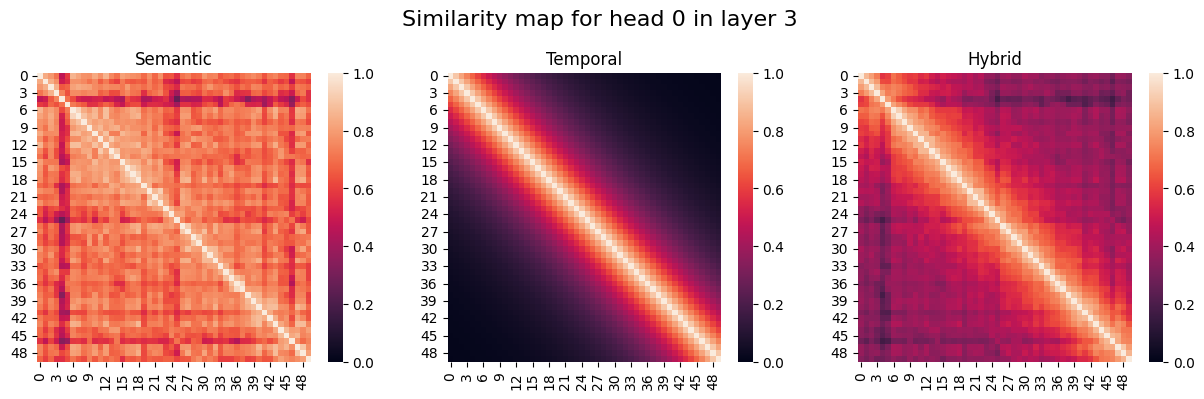

In [43]:
# plot 3 similarity matrices 
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_maps_head(i, layer_idx, sample_idx=0):
    fig, ax = plt.subplots(1, 3, figsize=(15, 3.75))
    fig.suptitle('Similarity map for head {} in layer {}'.format(i,layer_idx), fontsize=16, y=1.05)
    sns.heatmap(layer3[sample_idx][i]["semantic"], ax=ax[0], vmin=0, vmax=1)
    ax[0].set_title('Semantic')
    sns.heatmap(layer3[sample_idx][i]["temporal"], ax=ax[1], vmin=0, vmax=1)
    ax[1].set_title('Temporal')
    sns.heatmap(layer3[sample_idx][i]["hybrid"], ax=ax[2], vmin=0, vmax=1)
    ax[2].set_title('Hybrid')

    plt.show()

plot_similarity_maps_head(0, 3, sample_idx=0)
    

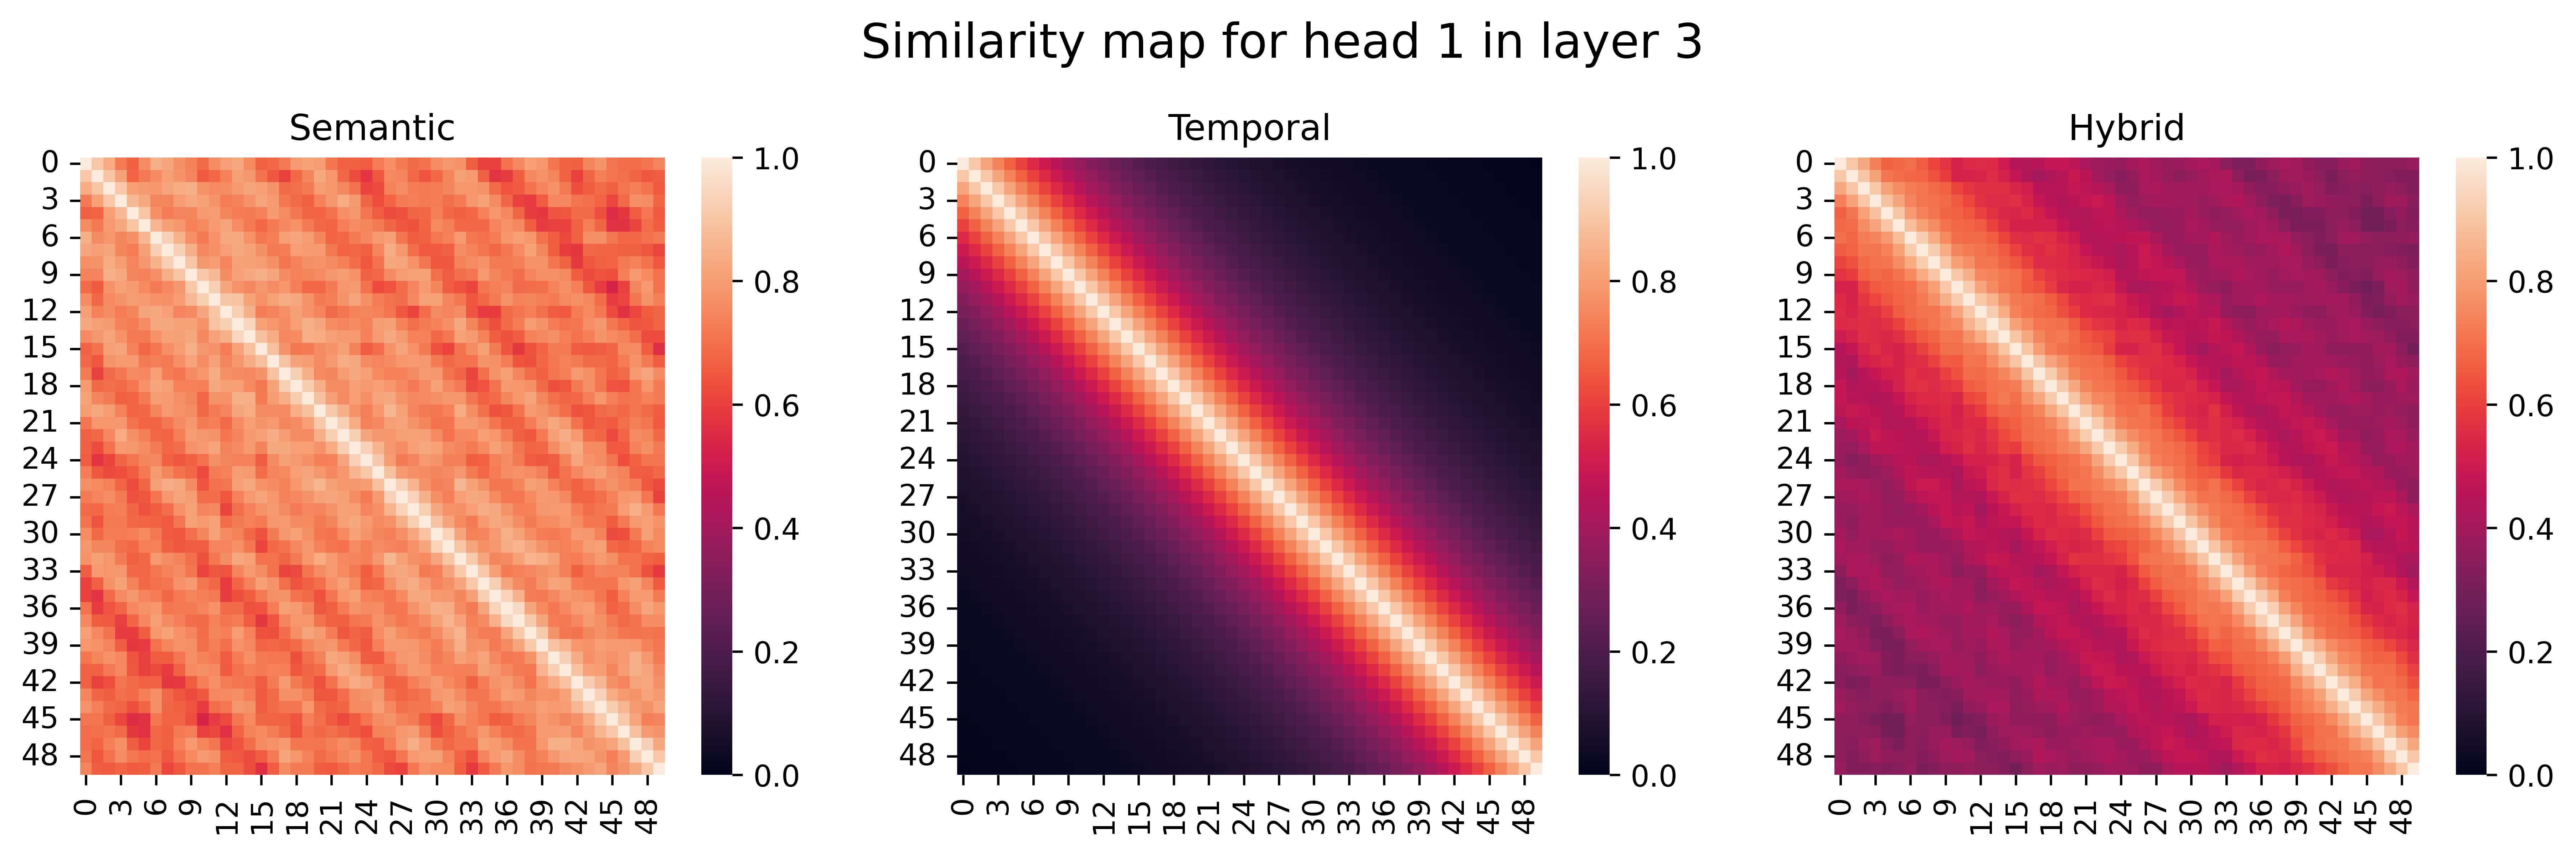

In [40]:
plot_similarity_maps_head(1, 3, sample_idx=0)

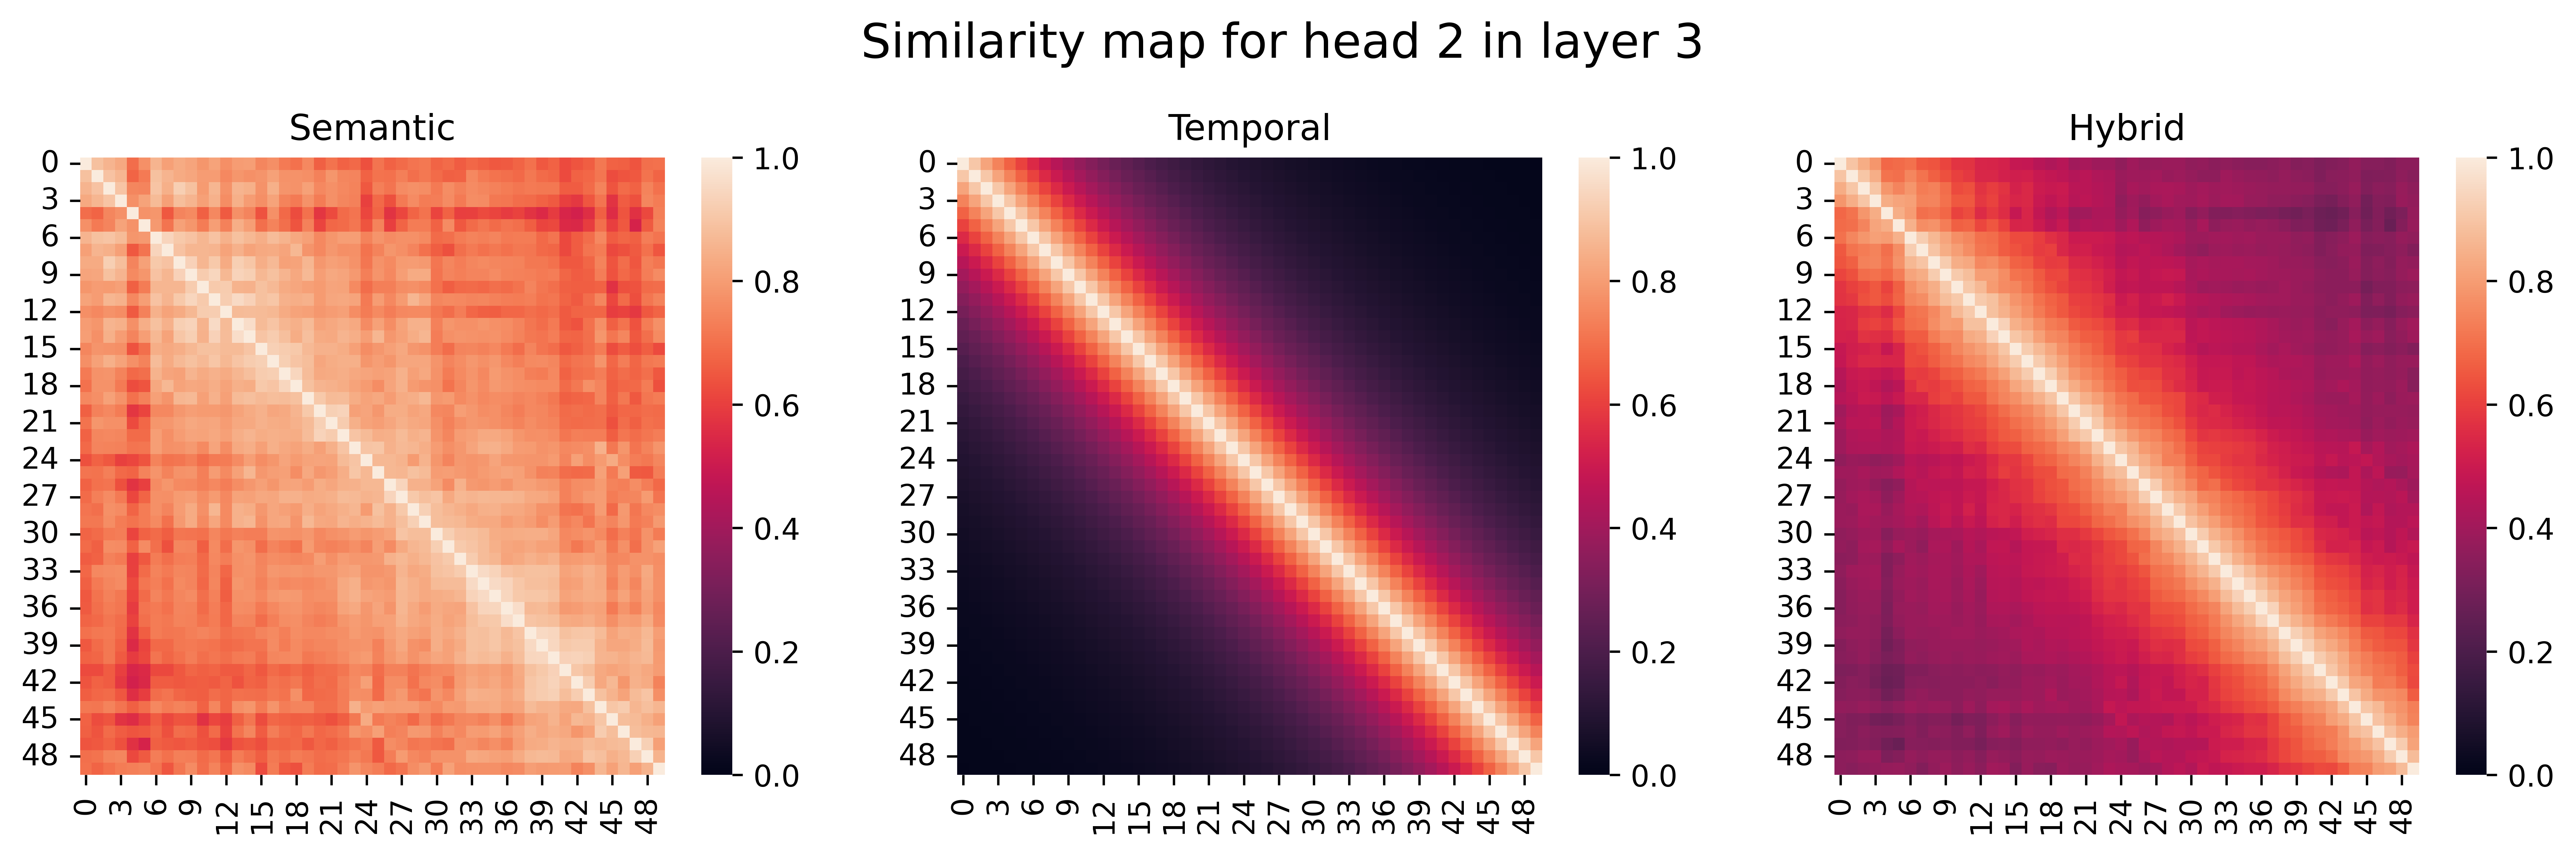

In [41]:
plot_similarity_maps_head(2, 3, sample_idx=0)